In [1]:
import re
from os.path import dirname, join

import keras.backend as keras_backend
from keras.layers import Conv1D, Lambda, Add
import numpy as np
import matplotlib.pylab as plt

from traits.api import Enum, HasStrictTraits, Int, Instance, List, Tuple

from blusky.transforms.apply_father_wavelet_1d import ApplyFatherWavlet1D
from blusky.transforms.cascade_tree import CascadeTree
from blusky.transforms.cascade_1d import Cascade1D
import blusky.datasets as datasets
from blusky.transforms.default_decimation import (NoDecimation, 
                                                  DefaultDecimation)
from blusky.transforms.i_decimation_method import IDecimationMethod
from blusky.wavelets.i_wavelet_1d import IWavelet1D
from blusky.utils.pad_1d import pad_to_log2, Pad1D

from blusky.wavelets.wavelet_factories_1d import (morlet_freq_1d,
                                                  vanilla_gabor_1d, 
                                                  vanilla_morlet_1d)

Using TensorFlow backend.


In [2]:
base_directory = join(dirname(datasets.__file__), "scatnet")

In [3]:
ts = np.genfromtxt(join(base_directory, 'timeseries.csv'),
                   delimiter=',', 
                   skip_header=1)

npad = 128
padded = np.pad(ts[:128,1], (npad//2,npad//2), mode='reflect')

wav = vanilla_morlet_1d(0.001, 5, 0)
psi1 = wav.kernel(npad+1)

wav = vanilla_morlet_1d(0.001, 5, 1)
psi2 = wav.kernel(npad+1)

wav = vanilla_morlet_1d(0.001, 5, 2)
psi3 = wav.kernel(npad+1)

wav = vanilla_morlet_1d(0.001, 5, 3)
psi4 = wav.kernel(npad+1)

wav = vanilla_morlet_1d(0.001, 5, 4)
psi5 = wav.kernel(npad+1)

wav = vanilla_gabor_1d(0.001, 5)
phi = wav.kernel(128)

res = np.convolve(np.abs(np.convolve(padded, psi1, mode='valid')), 
            phi, mode='valid') 
print ("|x*psi1|*phi : ", res.real)

res = np.convolve(np.abs(np.convolve(padded, psi2, mode='valid')), 
            phi, mode='valid') 
print ("|x*psi2|*phi : ", res.real)

res = np.convolve(np.abs(np.convolve(padded, psi3, mode='valid')), 
            phi, mode='valid') 
print ("|x*psi3|*phi : ", res.real)

res = np.convolve(np.abs(np.convolve(padded, psi4, mode='valid')), 
            phi, mode='valid') 
print ("|x*psi4|*phi : ", res.real)

res = np.convolve(np.abs(np.convolve(padded, psi5, mode='valid')), 
            phi, mode='valid') 
print ("|x*psi5|*phi : ", res.real)

|x*psi1|*phi :  [5.66458221]
|x*psi2|*phi :  [7.49797662]
|x*psi3|*phi :  [10.71004607]
|x*psi4|*phi :  [9.54639273]
|x*psi5|*phi :  [27.59855115]


/Users/blasscock/Documents/Code/sandia-blusky/blusky/wavelets/wavelet_factories_1d.py:46: RuntimeWarning: invalid value encountered in double_scalars
  step = np.pi * 2**(-J/Q) * (1-1/4*sigma0/_sigma_phi*2**(1./Q))/P


In [4]:
from blusky.wavelets.wavelet_factories_1d import (vanilla_gabor_1d, 
                                                  vanilla_morlet_1d,
                                                  calibrate_wavelets_1d)
from keras.layers import Input
from keras import Model

N = 128
order = 2
sample_rate = 0.001
oversampling = 1
conv_padding = "valid"
J = 5

wavelets = [vanilla_morlet_1d(sample_rate, J, j=i) 
                    for i in range(0,J)]
calibrate_wavelets_1d(wavelets)

father_wavelet = vanilla_gabor_1d(sample_rate, J)

deci = DefaultDecimation(oversampling=oversampling)
inp = Input(shape=(N,1))

# pad
pad_1d = Pad1D(wavelets, decimation=deci, conv_padding=conv_padding)
padded = pad_1d.pad(inp)

#
cascade_tree = CascadeTree(padded, order=order)

cascade = Cascade1D(decimation=deci, _padding=conv_padding)
convs = cascade.transform(cascade_tree, wavelets=wavelets)

# Create layers to remove padding
cascade_tree = CascadeTree(padded, order=order)
cascade_tree.generate(wavelets, pad_1d.unpad)
unpad = cascade_tree.get_convolutions()

# Remove the padding
unpadded_convs = [i[1](i[0]) for i in zip(convs, unpad)]

appl = ApplyFatherWavlet1D(wavelet=father_wavelet, 
                           J=J, 
                           img_size=(N,), 
                           sample_rate=sample_rate)
sca_transf = appl.convolve(unpadded_convs)

model = Model(inputs=inp, outputs=sca_transf)
_model = Model(inputs=inp, outputs=unpadded_convs)

ts = np.genfromtxt(join(base_directory, 'timeseries.csv'),
        delimiter=',', skip_header=1)

data = np.zeros((1,N,1))
data[0,:,0] = ts[:N,1]

result = model.predict(data)
_result = _model.predict(data)



Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


/Users/blasscock/Documents/Code/sandia-blusky/blusky/wavelets/wavelet_factories_1d.py:46: RuntimeWarning: invalid value encountered in double_scalars
  step = np.pi * 2**(-J/Q) * (1-1/4*sigma0/_sigma_phi*2**(1./Q))/P


In [5]:
_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 1)       0                                            
__________________________________________________________________________________________________
reflection_padding1d_1 (Reflect (None, 256, 1)       0           input_1[0][0]                    
__________________________________________________________________________________________________
reflection_padding1d_2 (Reflect (None, 263, 1)       0           reflection_padding1d_1[0][0]     
__________________________________________________________________________________________________
reflection_padding1d_3 (Reflect (None, 271, 1)       0           reflection_padding1d_1[0][0]     
__________________________________________________________________________________________________
reflection

In [10]:
result = np.squeeze(result)

In [11]:
result

array([ 5.5963373,  7.408911 , 10.7206335,  9.6476755, 26.022112 ,
        1.3639561,  1.1336482,  0.6267049,  0.8982139,  1.9767132,
        3.1654398,  2.3594644,  2.9675317,  1.4647076,  7.298035 ],
      dtype=float32)

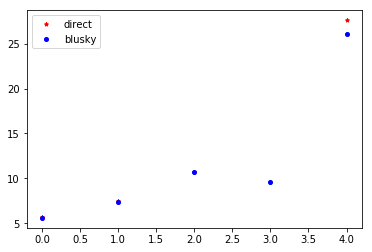

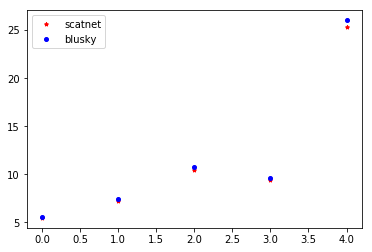

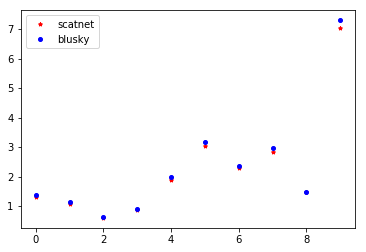

In [12]:
# direct method (above)
direct = [5.66458221, 7.49797662, 10.71004607, 9.54639273, 27.59855115]

# scatnet solution with ds/2 -> ds change
first_order = [5.4714, 7.2365, 10.4748, 9.4107, 25.3561]
second_order = [1.3031, 1.0821, 0.5982, 0.8612, 1.8940, 3.0288, 2.2791,
                2.8406, 1.4867, 7.0400]

# direct computation (conv above, not padding)
plt.figure()
plt.plot(direct , 'r*', markersize=4)
plt.plot(result[:5] , 'bo', markersize=4)
plt.legend(['direct', 'blusky'])
plt.show()

# scatnet vs blusky 
plt.figure()
plt.plot(first_order , 'r*', markersize=4)
plt.plot(result[:5] , 'bo', markersize=4)
plt.legend(['scatnet', 'blusky'])
plt.show()

plt.figure()
plt.plot(second_order , 'r*', markersize=4)
plt.plot(result[5:] , 'bo', markersize=4)
plt.legend(['scatnet', 'blusky'])
plt.show()